In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# Install required libraries
!pip install datasets huggingface_hub
!apt-get install git-lfs
!pip install accelerate -U
! pip install -U transformers

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('drive/MyDrive/training.csv', encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [ ]:
import pandas as pd
import re

In [ ]:

df['text'].dropna(inplace=True)
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
df['text'] = df['text'].apply(lambda x: re.sub(r'[^A-Za-z\s]+', '', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot a thats a bummer you shoulda got da...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan i dived many times for the ball manag...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving at all im ...


In [ ]:
df = df.drop(['date', 'flag','user'], axis=1)
df['target'] = df['target'].map({0: 0, 4: 1 , 2:2})


In [ ]:
df_sampled = df.sample(n=5000, random_state=42)

In [ ]:
df_sampled = df_sampled[['text', 'target']]
df_sampled.rename(columns={'target': 'labels'}, inplace=True)


In [ ]:
df_sampled

,text,labels
541200,chrishasboobs ahhh i hope your ok,0
750,misstoriblack cool i have no tweet apps for my...,0
766711,tiannachaos i know just family drama its lameh...,0
285055,school email wont open and i have geography st...,0
705995,upper airways problem,0
...,...,...
1147394,beartwinsmom thanks sweetie,1
1206971,pogue i was making a play on the term quotvirt...,1
422260,morning tweeple london is awash with precipita...,0
450957,still with my mother i wanna go homee,0


In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict


train_df, test_df = train_test_split(df_sampled, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})


In [ ]:
small_train_dataset = dataset["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = dataset["test"].shuffle(seed=42).select([i for i in list(range(300))])


In [ ]:
small_train_dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 540
})

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=376, training_loss=0.47444656047415223, metrics={'train_runtime': 92.7878, 'train_samples_per_second': 64.664, 'train_steps_per_second': 4.052, 'total_flos': 50826085021824.0, 'train_loss': 0.47444656047415223, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.4682040512561798,
 'eval_accuracy': 0.79,
 'eval_f1': 0.7934426229508197,
 'eval_runtime': 1.8075,
 'eval_samples_per_second': 165.978,
 'eval_steps_per_second': 10.512,
 'epoch': 2.0}

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1720356524.739706d298e2.4340.4:   0%|          | 0.00/457 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pouriaaa/finetuning-sentiment-model-3000-samples/commit/21a265affdc6d2eaeebdba1682ecc6ce8376a976', commit_message='End of training', commit_description='', oid='21a265affdc6d2eaeebdba1682ecc6ce8376a976', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:

from transformers import pipeline

sentiment_model = pipeline(model="federicopascual/finetuning-sentiment-model-3000-samples")

sentiment_model(["I love this move", "This movie sucks!"])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_1', 'score': 0.9558863043785095},
 {'label': 'LABEL_0', 'score': 0.9413502216339111}]

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('drive/MyDrive/training.csv', encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [ ]:
import pandas as pd
import re

In [ ]:

df['text'].dropna(inplace=True)

df['text'] = df['text'].str.lower()

df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
df['text'] = df['text'].apply(lambda x: re.sub(r'[^A-Za-z\s]+', '', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Display the first few rows of the cleaned DataFrame
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot a thats a bummer you shoulda got da...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan i dived many times for the ball manag...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving at all im ...


In [ ]:
df = df.drop(['date', 'flag','user'], axis=1)
df.head()

,target,ids,text
0,0,1467810369,switchfoot a thats a bummer you shoulda got da...
1,0,1467810672,is upset that he cant update his facebook by t...
2,0,1467810917,kenichan i dived many times for the ball manag...
3,0,1467811184,my whole body feels itchy and like its on fire
4,0,1467811193,nationwideclass no its not behaving at all im ...


In [ ]:
import random

special_characters = ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿',
                      'Ā', 'ā', 'Ă', 'ă', 'Ą', 'ą', 'Ć', 'ć', 'Ĉ', 'ĉ', 'Ċ', 'ċ', 'Č', 'č', 'Ď', 'ď', 'Đ', 'đ', 'Ē', 'ē', 'Ĕ', 'ĕ', 'Ė', 'ė', 'Ę', 'ę', 'Ě', 'ě', 'Ĝ', 'ĝ', 'Ğ', 'ğ',
                      'Ġ', 'ġ', 'Ģ', 'ģ', 'Ĥ', 'ĥ', 'Ħ', 'ħ', 'Ĩ', 'ĩ', 'Ī', 'ī', 'Ĭ', 'ĭ', 'Į', 'į', 'İ', 'ı', 'Ĳ', 'ĳ', 'Ĵ', 'ĵ', 'Ķ', 'ķ', 'ĸ', 'Ĺ', 'ĺ', 'Ļ', 'ļ', 'Ľ', 'ľ', 'Ŀ', 'ŀ',
                      'Ł', 'ł', 'Ń', 'ń', 'Ņ', 'ņ', 'Ň', 'ň', 'ŉ', 'Ŋ', 'ŋ', 'Ō', 'ō', 'Ŏ', 'ŏ', 'Ő', 'ő', 'Œ', 'œ', 'Ŕ', 'ŕ', 'Ŗ', 'ŗ', 'Ř', 'ř', 'Ś', 'ś', 'Ŝ', 'ŝ', 'Ş', 'ş', 'Š', 'š',
                      'Ţ', 'ţ', 'Ť', 'ť', 'Ŧ', 'ŧ', 'Ũ', 'ũ', 'Ū', 'ū', 'Ŭ', 'ŭ', 'Ů', 'ů', 'Ű', 'ű', 'Ų', 'ų', 'Ŵ', 'ŵ', 'Ŷ', 'ŷ', 'Ÿ', 'Ź', 'ź', 'Ż', 'ż', 'Ž', 'ž',
                      'Ͱ', 'ͱ', 'Ͳ', 'ͳ', 'ʹ', '͵', 'Ͷ', 'ͷ', 'ͺ', 'ͻ', 'ͼ', 'ͽ', ';', 'Ϳ', 'Ά', '·', 'Έ', 'Ή', 'Ί', 'Ό', 'Ύ', 'Ώ', 'ΐ', 'Α', 'Β', 'Γ', 'Δ', 'Ε', 'Ζ', 'Η', 'Θ', 'Ι',
                      'Κ', 'Λ', 'Μ', 'Ν', 'Ξ', 'Ο', 'Π', 'Ρ', 'Σ', 'Τ', 'Υ', 'Φ', 'Χ', 'Ψ', 'Ω', 'Ϊ', 'Ϋ', 'ά', 'έ', 'ή', 'ί', 'ΰ', 'α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ',
                      'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω', 'ϊ', 'ϋ', 'ό', 'ύ', 'ώ', 'Ϗ', 'ϐ', 'ϑ', 'ϒ', 'ϓ', 'ϔ', 'ϕ', 'ϖ', 'ϗ', 'Ϙ', 'ϙ', 'Ϛ', 'ϛ',
                      'Ϝ', 'ϝ', 'Ϟ', 'ϟ', 'Ϡ', 'ϡ', 'Ϣ', 'ϣ', 'Ϥ', 'ϥ', 'Ϧ', 'ϧ', 'Ϩ', 'ϩ', 'Ϫ', 'ϫ', 'Ϭ', 'ϭ', 'Ϯ', 'ϯ',
                      'А', 'В', 'Е', 'К', 'М', 'Н', 'О', 'Р', 'С', 'Т', 'У', 'Х', 'а', 'в', 'е', 'к', 'м', 'н', 'о', 'р', 'с', 'т', 'у', 'х']


homoglyphs = {
    'A': ['Α', 'А', 'Ꭺ', 'ᗅ', 'ᴀ','Λ'],
    'B': ['Β', 'В', 'ß', '฿'],
    'C': ['Ϲ', 'С', 'Ⲥ', 'Ͼ'],
    'E': ['Ε', 'Е', 'ⴹ', 'ᴇ'],
    'H': ['Η', 'Н', 'Ⲏ', 'ɦ'],
    'I': ['Ι', 'І', 'Ⅰ', '1'],
    'J': ['Ј', 'ϳ', 'Ɉ'],
    'K': ['Κ', 'К', 'Ⲕ', 'ᛕ'],
    'M': ['Μ', 'М', 'Ⲙ', '𐓑'],
    'N': ['Ν', 'Ⲛ', '⋒','Ń', 'Ņ', 'Ň'],
    'O': ['Ο', 'О', 'Ⲟ', '0','Ō', 'ō', 'Ŏ', 'ŏ', 'Ő', 'ő'],
    'P': ['Ρ', 'Р', 'Ⲣ', 'Ꮲ'],
    'S': ['Ѕ', 'Ⲥ', '𐑈'],
    'T': ['Τ', 'Т', 'Ⲧ', '⟙'],
    'X': ['Χ', 'Х', 'Ⲭ', '𐍇','χ'],
    'Y': ['Υ', 'У', 'Ү', 'Ӯ'],
    'a': ['а', 'ɑ', 'ạ', 'ạ'],
    'b': ['Ƅ', 'ь', 'ƅ'],
    'c': ['с', 'ƈ'],
    'd': ['ԁ', 'ɗ'],
    'e': ['е', 'ə'],
    'g': ['ɡ'],
    'h': ['һ'],
    'i': ['і', 'ɩ'],
    'j': ['ј'],
    'k': ['κ'],
    'l': ['ӏ'],
    'm': ['м'],
    'n': ['ո', 'ń','ņ','ň', 'ŉ', 'Ŋ', 'ŋ','Π'],
    'o': ['о', 'ɵ'],
    'p': ['р'],
    's': ['ѕ'],
    't': ['т'],
    'u': ['υ'],
    'v': ['ν'],
    'w': ['ѡ','Ϣ', 'ϣ','Ψ'],
    'x': ['х'],
    'y': ['у'],
    'z': ['ᴢ']
}


def add_special_characters(text, noise_level=0.1):
    chars = list(text)
    num_chars = len(chars)
    num_noise_chars = int(noise_level * num_chars)
    for _ in range(num_noise_chars):
        idx = random.randint(0, num_chars - 1)
        chars.insert(idx, random.choice(special_characters))
    return ''.join(chars)


def replace_with_homoglyphs(text, noise_level=0.1):
    chars = list(text)
    num_chars = len(chars)
    num_replacements = int(noise_level * num_chars)
    for _ in range(num_replacements):
        idx = random.randint(0, num_chars - 1)
        if chars[idx] in homoglyphs:
            chars[idx] = random.choice(homoglyphs[chars[idx]])
    return ''.join(chars)

original_text = "Example text to be modified."
noisy_text_with_special_chars = add_special_characters(original_text, noise_level=0.2)
noisy_text_with_homoglyphs = replace_with_homoglyphs(original_text, noise_level=0.8)

print("Original Text:", original_text)
print("Noisy Text with Special Characters:", noisy_text_with_special_chars)
print("Noisy Text with Homoglyphs:", noisy_text_with_homoglyphs)


In [ ]:
df['target'] = df['target'].map({0:0, 4:1})
df_sampledd = df.sample(n=200, random_state=42)
max_words = 50  # Adjust this value as needed

# Limit the sequence length of the "text" column based on words
#def truncate_text(text, max_words):
    #words = text.split()
    #return ' '.join(words[:max_words])

#df_sampled['text'] = df_sampled['text'].apply(lambda x: truncate_text(x, max_words))

# Display the first few rows to check the changes
print(df.head())

In [ ]:
df_sampledd

,target,ids,text
541200,0,2200003196,chrishasboobs ahhh i hope your ok
750,0,1467998485,misstoriblack cool i have no tweet apps for my...
766711,0,2300048954,tiannachaos i know just family drama its lameh...
285055,0,1993474027,school email wont open and i have geography st...
705995,0,2256550904,upper airways problem
...,...,...,...
822605,1,1555730383,thank you everyone i seriously am i lucky guy ...
143042,0,1881627162,friday gimmick in the office but always lookin...
1533629,1,2178551287,talk meeting tonight at tampa chamber at pm wi...
1059695,1,1963285980,successfully obtained visa entries to enter an...


In [ ]:
!pip3 install emoji==0.6.0

In [ ]:
sentiment_model = pipeline(model="federicopascual/finetuning-sentiment-model-3000-samples")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
from sklearn.metrics import accuracy_score

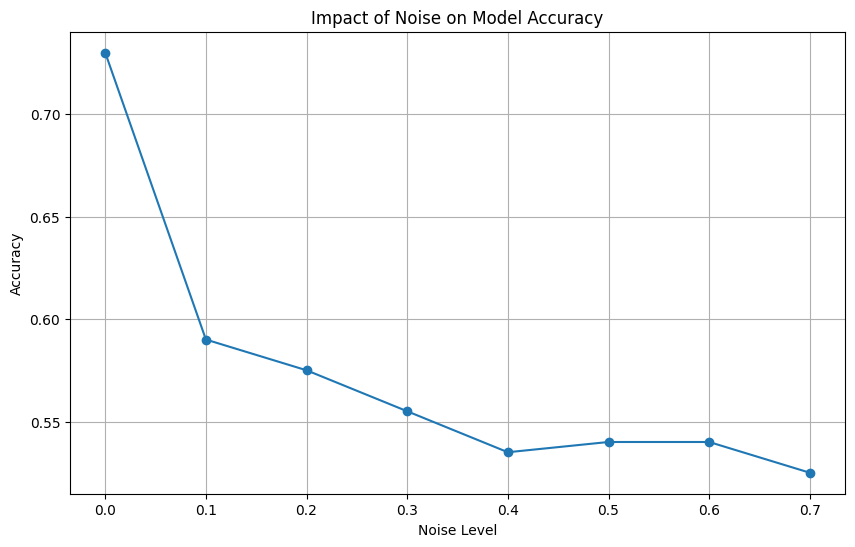

In [ ]:
import matplotlib.pyplot as plt
def calculate_accuracy(df, noise_level):
    df_noisy = df.copy()
    df_noisy['text'] = df_noisy['text'].apply(lambda x: replace_with_homoglyphs(x, noise_level))


    data = df_noisy['text'].tolist()


    results = sentiment_model(data)

    labels = [result['label'] for result in results]
    df_noisy['predicted_sentiment'] = [0 if result['label'] == 'LABEL_0' else 1 for result in results]

    df_noisy['predicted_sentiment'] = df_noisy['predicted_sentiment'].astype(int)
    df_noisy['target'] = df_noisy['target'].astype(int)

    accuracy = accuracy_score(df_noisy['target'],df_noisy['predicted_sentiment'])
    return accuracy


noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7]

accuracy_results = {}

for noise_level in noise_levels:
    accuracy = calculate_accuracy(df_sampledd, noise_level)
    accuracy_results[noise_level] = accuracy
    print(f'Noise Level: {noise_level}, Accuracy: {accuracy}')

plt.figure(figsize=(10, 6))
plt.plot(accuracy_results.keys(), accuracy_results.values(), marker='o')
plt.title('Impact of Noise on Model Accuracy')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()